### Single Nucleus
Benchmarking for this notebook:
 - Processors: 8 x AMD EPYC 7542 32-Core
 - Runtime: 03:14:13 (hh:mm:ss)
 - Memory utilized: 73.01 GB

#### HTAPP-895-SMP-7359

In [1]:
# Set paths to data and result
path_to_data <- "path/to/data/"
path_to_results <- "path/to/results/"

In [2]:
libraries <- c("ggplot2", "Seurat", "glue", "dplyr", "anndata", 
               "data.table", "Matrix", "mltools", "enrichR", "R.utils")
lapply(libraries, function(x) suppressMessages(require(x, character.only = TRUE,quietly=TRUE,warn.conflicts = FALSE)))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

In [3]:
sample <- "HTAPP-895-SMP-7359"

In [5]:
# Assumes you're working in the repository root directory
source("code/utils.R")

##### If starting from anndata inputs

In [6]:
# Otherwise skip this section and start directly with counts and cell/nucleus metadata objects

In [8]:
#library(reticulate)
#use_condaenv(condaenv = "SlideCNA_env") #if error, set conda environment manually for reticulate
sn_adata <- read_h5ad(paste0(path_to_data, sample, "_scRNAseq_processed.h5ad"))

In [8]:
counts <- get_adata_counts(sn_adata)
colnames(counts) <- sub(glue('^{sample}-TST-channel1_'), '', colnames(counts))

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


##### If starting from raw inputs

In [6]:
# Read in data
counts <- read.table(paste0(path_to_data, sample, "_scRNA-seq_counts.txt"), check.names = FALSE)
cells_df <- readRDS(paste0(path_to_data, sample, "_scRNA-seq_cells_df.rds"))

In [7]:
write.table(cells_df, paste0(path_to_data, sample, "_scRNA-seq_cells_df.txt"))

In [8]:
cells_df <- read.table(paste0(path_to_data, sample, "_scRNA-seq_cells_df.txt"), check.names = FALSE)

In [10]:
cells_df <- cells_df %>% mutate_at(c('replicate', 'condition', 'labels_unif',
                         'labels_cl_unif', 'labels_cl_unif2_broad', 
                         'compartments', 'cnv_pass_mal', 'leiden'),
                       as.factor)


In [30]:
# data.frame of sn/scRNA-seq counts genes x cells/nuclei
head(counts)

,HTAPP-895-SMP-7359-TST-channel1_AACCAACGTAATGCTC-1,HTAPP-895-SMP-7359-TST-channel1_GATCAGTTCTTACCGC-1,HTAPP-895-SMP-7359-TST-channel1_TGGTACAGTATGCTTG-1,HTAPP-895-SMP-7359-TST-channel1_CATGCTCCACGACCTG-1,HTAPP-895-SMP-7359-TST-channel1_CACGAATAGGTAATCA-1,HTAPP-895-SMP-7359-TST-channel1_TATGTTCTCACCTCAC-1,HTAPP-895-SMP-7359-TST-channel1_TAAGCCATCCTAGCCT-1,HTAPP-895-SMP-7359-TST-channel1_GGAAGTGTCGCTAAAC-1,HTAPP-895-SMP-7359-TST-channel1_CTGCCTACAGTAACAA-1,HTAPP-895-SMP-7359-TST-channel1_ATGAGGGCACACGTGC-1,...,HTAPP-895-SMP-7359-TST-channel2_TGGTAGTGTTCCTTGC-1,HTAPP-895-SMP-7359-TST-channel2_CGATCGGAGTATGGAT-1,HTAPP-895-SMP-7359-TST-channel2_GTTGTCCGTGGAATGC-1,HTAPP-895-SMP-7359-TST-channel2_ACTATTCAGCGCTGCT-1,HTAPP-895-SMP-7359-TST-channel2_TACCCACGTTCTTCAT-1,HTAPP-895-SMP-7359-TST-channel2_AGCGCCACAAACACCT-1,HTAPP-895-SMP-7359-TST-channel2_TTCACCGCAGCCGTTG-1,HTAPP-895-SMP-7359-TST-channel2_GACACGCCATCTCATT-1,HTAPP-895-SMP-7359-TST-channel2_ACGTACATCTGTTCAT-1,HTAPP-895-SMP-7359-TST-channel2_GTTATGGCAGTATGAA-1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC114498.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL669831.5,2,1,2,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
FAM87B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# data.frame of cell/nucleus metadata (cells/nuclei x annotations)
# must contain columns 'bc' with values of cell/nucleus names, 'cell_type' with cell types,
# and 'nCount_RNA' with RNA counts per bead
head(cells_df)

,replicate,condition,cell_type,labels_unif,labels_cl_unif,labels_cl_unif2_broad,compartments,cnv_pass_mal,Phase,n_genes_by_counts,total_counts,pct_counts_mt,n_counts,n_genes,total_counts_mt,leiden,bc
,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>,<chr>
AACCAACGTAATGCTC-1,1,TST,MBC,Epithelial,Epithelial,Epithelial,Malignant,True,G1,7670,18898,7.551064,18898,7670,1427,8,AACCAACGTAATGCTC-1
GATCAGTTCTTACCGC-1,1,TST,MBC,Epithelial,Epithelial,Epithelial,Malignant,True,G1,7349,19307,12.363391,19307,7349,2387,3,GATCAGTTCTTACCGC-1
TGGTACAGTATGCTTG-1,1,TST,MBC,Epithelial,Epithelial,Epithelial,Malignant,True,G2M,7621,18535,9.576477,18535,7621,1775,0,TGGTACAGTATGCTTG-1
CATGCTCCACGACCTG-1,1,TST,MBC,Epithelial,Epithelial,Epithelial,Malignant,True,G2M,7924,19107,10.666248,19107,7924,2038,0,CATGCTCCACGACCTG-1
CACGAATAGGTAATCA-1,1,TST,MBC,Epithelial,Epithelial,Epithelial,Malignant,True,G1,7663,19976,14.627554,19976,7663,2922,3,CACGAATAGGTAATCA-1
TATGTTCTCACCTCAC-1,1,TST,MBC,Epithelial,Epithelial,Epithelial,Malignant,True,G2M,7659,19827,8.321985,19827,7659,1650,0,TATGTTCTCACCTCAC-1


#### Create a Seurat Object from single-cell/single-nucleus data

In [9]:
# Reformat and filter counts
counts_mat <- counts %>% as.data.table() %>% sparsify()
counts_mat <- counts_mat[,colSums(counts_mat)>300] # filter for cells with over 300 counts across all genes
row.names(counts_mat) <- row.names(counts)

In [ ]:
counts_mat[1:5,1:5]

In [12]:
sn=make_seurat_annot(counts_mat, cells_df, seed_FindClusters = 0, seed_RunTSNE = 1, seed_RunUMAP = 42)

Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix

PC_ 1 
Positive:  COL4A2, COL4A1, IGFBP7, LAMA4, CALD1, SPARC, LDB2, NRP1, FN1, MSRB3 
	   CACNA1C, ADGRF5, NXN, NOX4, RBMS3, ERG, LAMB1, KALRN, ADGRL2, GLIS3 
	   DCLK2, TIMP3, UACA, CHSY3, COL15A1, NID1, PTPRE, ADAMTS9-AS2, ZNF521, HMCN1 
Negative:  KRT19, ADCY1, TFF1, RPLP0, ESRP1, IGFBP4, COX6C, TFF3, ADIRF, CHPT1 
	   LINC00536, TMBIM6, MAL2, RPLP1, AC013652.1, SHANK2, ZNF552, CA8, PPM1E, PLEKHA7 
	   MGP, DSP, AGBL4, SLC9A3R1, SET, RPS2, MPPED2, S100A6, HIST1H2AC, LDHA 
PC_ 2 
Positive:  MSR1, TFEC, GPNMB, FPR3, NPL, DOCK8, SLCO2B1, MARCH1, AC074327.1, COLEC12 
	   FMNL2, SLC1A3, PIK3AP1, ABCA1, ST18, ALOX5, ABR, SYK, APBB1IP, IL18 
	   CHST11, TMEM51, RASSF4, ITGAX, SIGLEC1, DAPK1, DOCK2, SLC11A1, SLC8A1, KCNE1 
Negative:  PTPRG, TEAD1, FBXL7, CALD1, COL4A2, PARD3, ANTXR1, DLC1, PRKG1, PARVA 
	   COL4A1, MSRB3, CACNA1C, SOX5, IGFBP7, IGFBP4, TIMP3, PALLD, PDZRN3, NXN 
	   NOX4, ZFPM2, LAMB1, PLOD2, COL3A

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9958
Number of edges: 306834

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8661
Number of communities: 16
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:15:47 UMAP embedding parameters a = 0.9922 b = 1.112

15:15:47 Read 9958 rows and found 10 numeric columns

15:15:47 Using Annoy for neighbor search, n_neighbors = 30

15:15:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:15:48 Writing NN index file to temp file /tmp/RtmpbjRANm/file15242b548d1322

15:15:48 Searching Annoy index using 1 thread, search_k = 3000

15:15:51 Annoy recall = 100%

15:15:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

In [13]:
# Annotate cells/nuclei as Malignant or Normal
sn@meta.data$cluster_type <- 'Malignant'
sn@meta.data[sn@meta.data$cell_type!='MBC',]$cluster_type <- 'Normal' # MBC = metastatic breast cancer
table(sn@meta.data$cell_type)
# unorder cell types
class(sn@meta.data$cell_type) <- setdiff(class(sn@meta.data$cell_type), "ordered")


                   MBC   Endothelial_vascular             Fibroblast 
                  6913                    230                    201 
Smooth muscle_vascular             Macrophage               B_plasma 
                    52                    851                    844 
                     B                      T                     NK 
                    11                    841                     15 

In [14]:
md=as.data.table(sn@meta.data)
rownames(md) <- md$bc

In [17]:
# outputting single nucleus results
saveRDS(sn, file.path(path_to_results, "sn.rds"))
saveRDS(md, file.path(path_to_results, "md.rds"))

In [17]:
# TSNE Plots

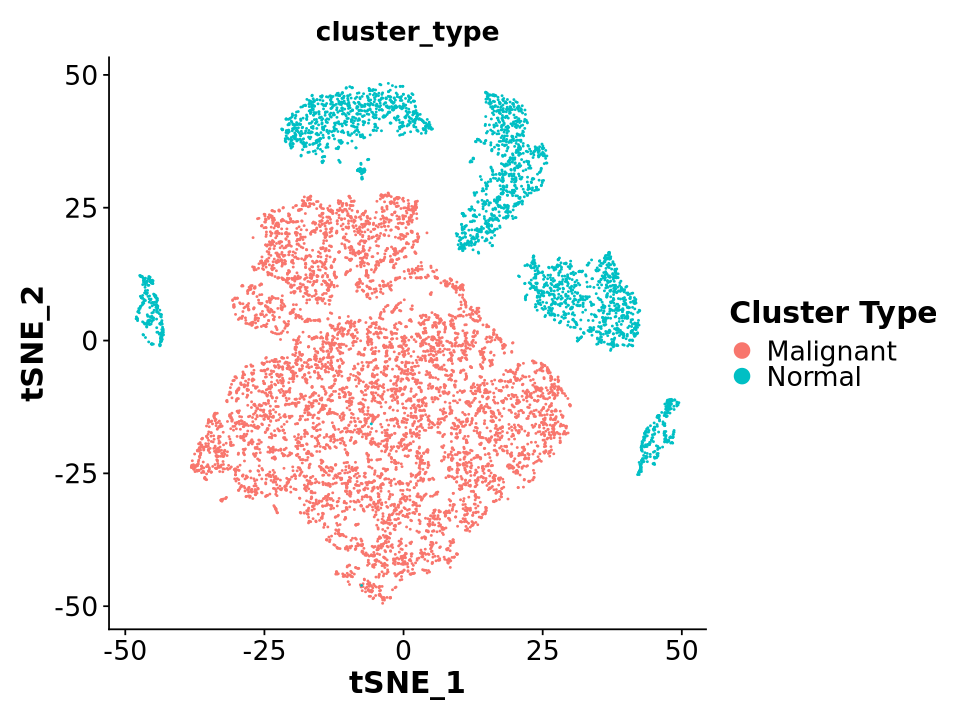

In [18]:
legend_title = "Cluster Type"
options(repr.plot.width = 8, repr.plot.height =6)
TSNEPlot(sn, label.size = 18, group.by="cluster_type") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

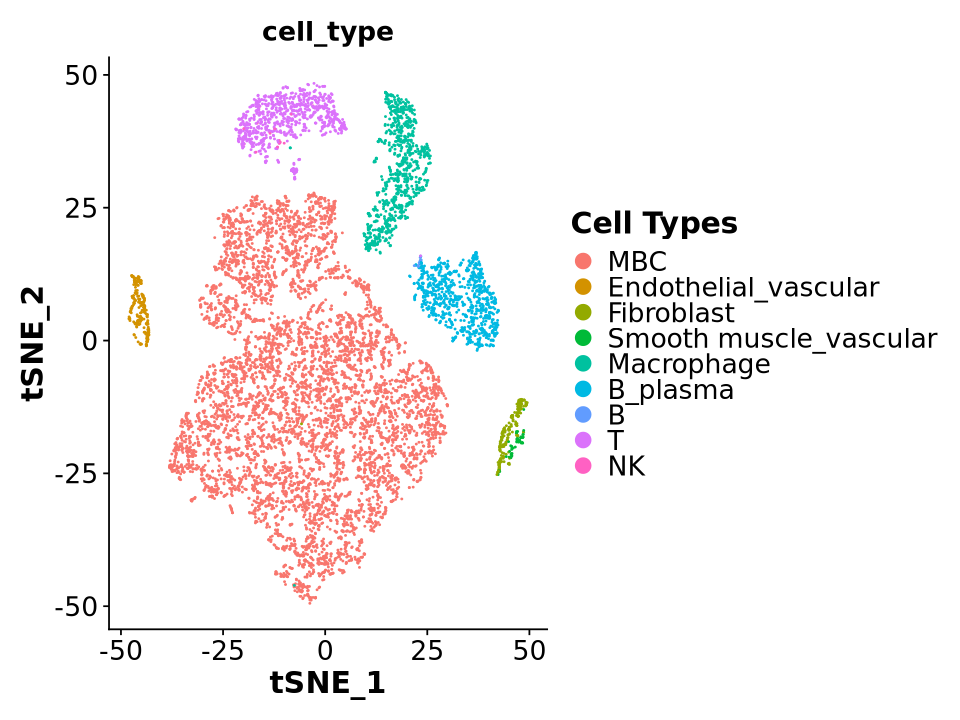

In [19]:
legend_title = "Cell Types"
options(repr.plot.width = 8, repr.plot.height =6)
TSNEPlot(sn, label.size = 18, group.by="cell_type") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

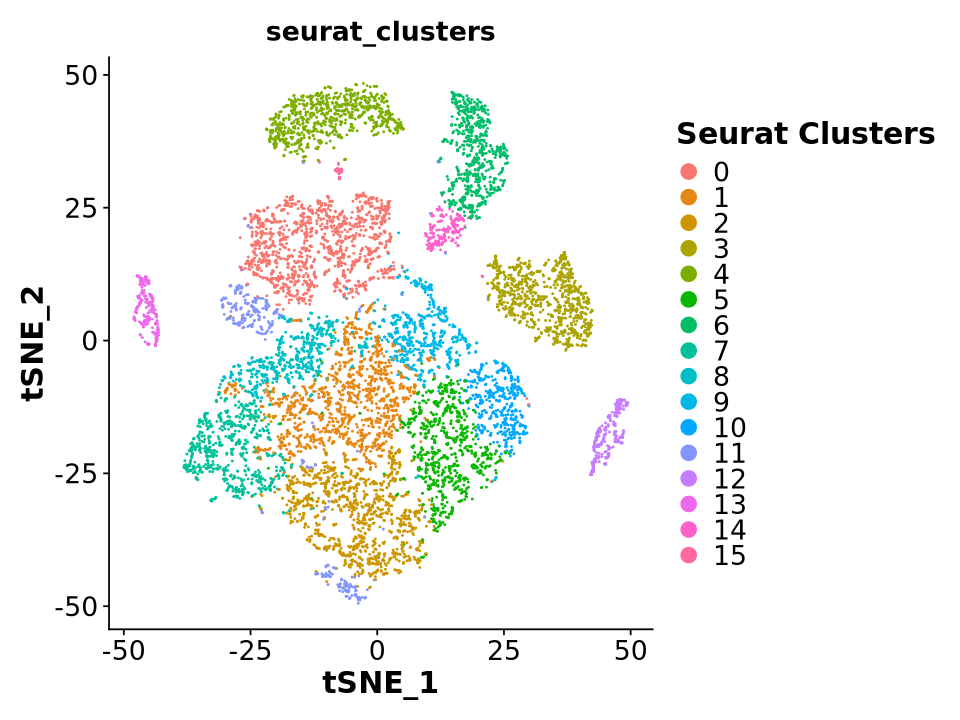

In [20]:
legend_title = "Seurat Clusters"
TSNEPlot(sn, label.size = 18, group.by="seurat_clusters") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

#### Cell Type Markers

In [21]:
sn <- SetIdent(sn,value = sn@meta.data$cell_type)
markers <- FindAllMarkers(sn,max.cells.per.ident = 500,random.seed = 1234)

Calculating cluster MBC

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster Endothelial_vascular

Calculating cluster Fibroblast

Calculating cluster Smooth muscle_vascular

Calculating cluster Macrophage

Calculating cluster B_plasma

Calculating cluster B

Calculating cluster T

Calculating cluster NK



In [22]:
markers <- markers %>% as.data.table()

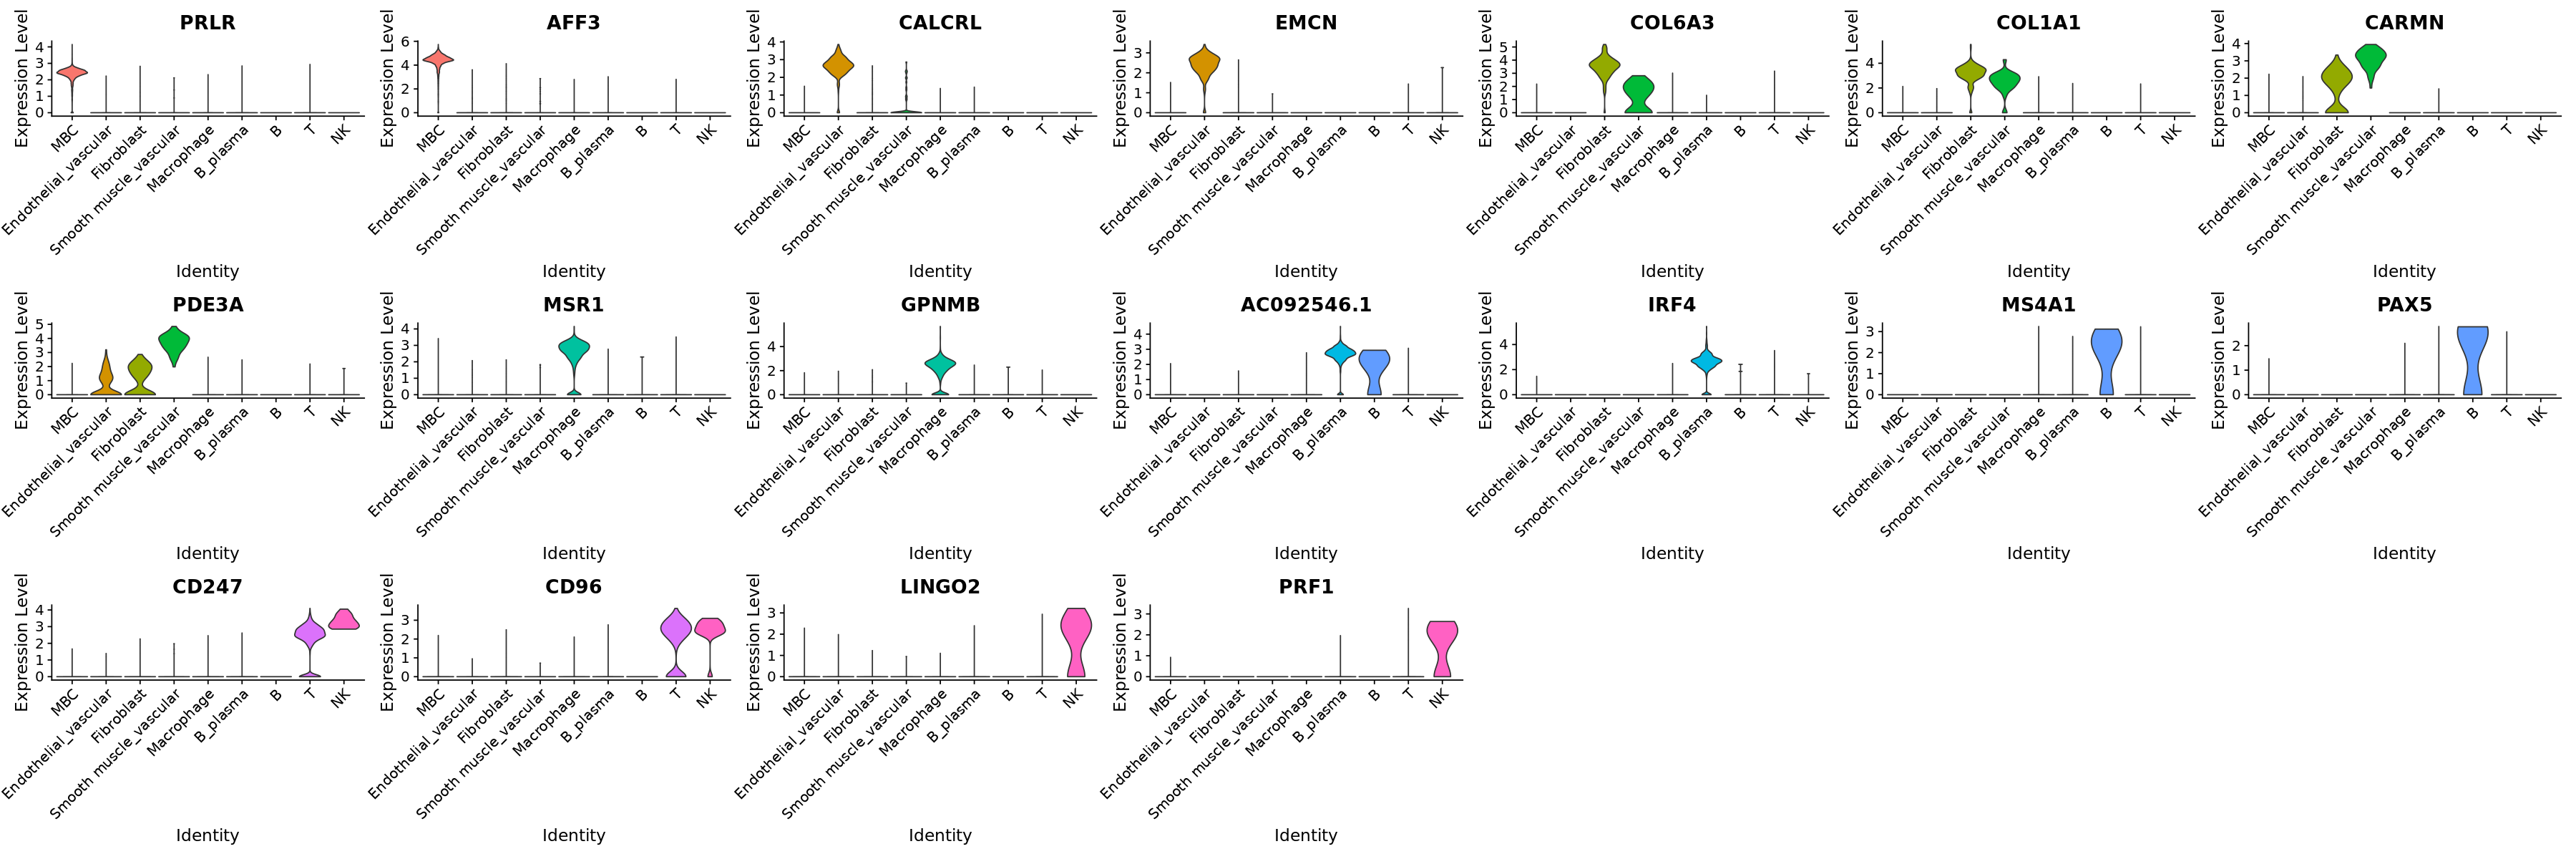

In [11]:
options(repr.plot.width = 30, repr.plot.height =10)
VlnPlot(sn,features = markers[pct.2<0.04,.SD[1:2],by="cluster"]$gene,group.by = "cell_type",ncol = 7,pt.size = 0)

In [22]:
saveRDS(markers, file=file.path(path_to_results, "markers.rds"))

In [25]:
head(markers)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.205819e-183,3.315140,0.988,0.021,8.150473e-179,MBC,PRLR
4.554283e-183,6.129776,0.995,0.039,1.157881e-178,MBC,AFF3
2.235159e-181,4.055812,0.983,0.016,5.682669e-177,MBC,ANKS1B
4.289059e-180,4.341707,0.980,0.016,1.090450e-175,MBC,ANKRD30A
3.479754e-179,3.563797,0.999,0.076,8.846926e-175,MBC,KRT19
8.201916e-179,2.772970,0.969,0.016,2.085255e-174,MBC,ADCY1


#### Seurat Cluster Markers

In [26]:
sn=SetIdent(sn,value = sn@meta.data$seurat_clusters)
seurat_markers=FindAllMarkers(sn)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [27]:
seurat_markers=as.data.table(seurat_markers)

In [25]:
saveRDS(seurat_markers, file=file.path(path_to_results, "seurat_markers.rds"))

In [30]:
seurat_markers[order(avg_log2FC,decreasing=TRUE),.SD[1:2,],by="cluster"]

cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,0.000000e+00,6.6573121,0.981,0.165,0.000000e+00,IGKC
3,0.000000e+00,6.3004981,0.980,0.250,0.000000e+00,IGHG3
13,1.718310e-209,5.8524866,0.987,0.298,4.368631e-205,INSR
13,0.000000e+00,4.6467082,0.952,0.093,0.000000e+00,ADAMTS6
12,0.000000e+00,5.4728497,0.992,0.063,0.000000e+00,CALD1
12,0.000000e+00,5.0242440,0.924,0.012,0.000000e+00,COL6A3
6,0.000000e+00,4.5723878,0.998,0.133,0.000000e+00,PLXDC2
6,0.000000e+00,4.4224244,0.998,0.296,0.000000e+00,FMNL2
4,0.000000e+00,4.1565708,0.913,0.049,0.000000e+00,TOX


In [31]:
# Get gene ontology terms associated with each cluster

In [32]:
en_seurat=seurat_markers[order(avg_log2FC,decreasing=TRUE),run_enrichr(gene,50),by="cluster"]

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  

In [33]:
en_seurat[GO_Biological_Process_2018.Adjusted.P.value<0.05][order(GO_Biological_Process_2018.Adjusted.P.value),.SD[1:3],by="cluster"]

cluster,GO_Biological_Process_2018.Term,GO_Biological_Process_2018.Overlap,GO_Biological_Process_2018.P.value,GO_Biological_Process_2018.Adjusted.P.value,GO_Biological_Process_2018.Old.P.value,GO_Biological_Process_2018.Old.Adjusted.P.value,GO_Biological_Process_2018.Odds.Ratio,GO_Biological_Process_2018.Combined.Score,GO_Biological_Process_2018.Genes
<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
9,SRP-dependent cotranslational protein targeting to membrane (GO:0006614),16/89,2.478492e-26,1.122757e-23,0,0,128.135375,7554.80560,RPL4;RPL41;RPLP1;RPLP0;RPL13A;RPL23A;RPS19;RPL14;RPL35;RPS20;RPS2;RPS11;RPS27A;RPL28;RPS24;RPL19
9,cotranslational protein targeting to membrane (GO:0006613),16/93,5.313378e-26,1.203480e-23,0,0,121.454545,7068.28832,RPL4;RPL41;RPLP1;RPLP0;RPL13A;RPL23A;RPS19;RPL14;RPL35;RPS20;RPS2;RPS11;RPS27A;RPL28;RPS24;RPL19
9,protein targeting to ER (GO:0045047),16/97,1.099494e-25,1.660235e-23,0,0,115.433551,6633.94051,RPL4;RPL41;RPLP1;RPLP0;RPL13A;RPL23A;RPS19;RPL14;RPL35;RPS20;RPS2;RPS11;RPS27A;RPL28;RPS24;RPL19
11,mitochondrial ATP synthesis coupled electron transport (GO:0042775),11/85,1.363244e-16,5.480242e-14,0,0,75.757450,2767.53283,MT-ND6;MT-ND4L;MT-ND4;MT-ND5;MT-CO1;MT-CO2;MT-CO3;MT-ND2;MT-CYB;MT-ND3;MT-ND1
11,respiratory electron transport chain (GO:0022904),11/94,4.341046e-16,8.725502e-14,0,0,67.512203,2388.12576,MT-ND6;MT-ND4L;MT-ND4;MT-ND5;MT-CO1;MT-CO2;MT-CO3;MT-ND2;MT-CYB;MT-ND3;MT-ND1
11,"mitochondrial electron transport, NADH to ubiquinone (GO:0006120)",7/46,1.957439e-11,2.622969e-09,0,0,83.110912,2049.24906,MT-ND6;MT-ND4L;MT-ND4;MT-ND5;MT-ND2;MT-ND3;MT-ND1
12,extracellular matrix organization (GO:0030198),14/229,2.905829e-16,1.479067e-13,0,0,35.696382,1277.02533,POSTN;ITGA1;FN1;COL1A1;VCAN;COL3A1;COL1A2;COL4A2;COL5A1;COL4A1;COL5A2;ITGA11;COL6A3;COL8A1
12,collagen fibril organization (GO:0030199),5/29,9.022909e-09,2.296330e-06,0,0,92.250000,1708.79278,COL1A1;COL3A1;COL1A2;COL5A1;COL5A2
12,protein complex subunit organization (GO:0071822),5/45,9.008593e-08,1.209357e-05,0,0,55.305556,897.19448,COL1A1;COL3A1;COL1A2;COL5A1;COL5A2


### Run SlideCNA

In [34]:
library(SlideCNA)


Attaching package: ‘SlideCNA’


The following object is masked _by_ ‘.GlobalEnv’:

    run_enrichr


The following object is masked from ‘package:Seurat’:

    SpatialPlot


The following object is masked from ‘package:base’:

    mode




In [35]:
gene_pos <- readRDS(file=file.path(path_to_data, "gene_pos.rds"))
sn <- readRDS(file=file.path(path_to_results, "sn.rds"))
md <- readRDS(file=file.path(path_to_results, "md.rds"))

In [36]:
OUTPUT_DIRECTORY <- file.path(path_to_results, "SlideCNA")
plotDir <- file.path(OUTPUT_DIRECTORY, "plots")
dir.create(OUTPUT_DIRECTORY)
dir.create(plotDir)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”
Warning message in `[.data.table`(new_md, , `:=`(N_bin, .N), by = bin_all):
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Warning message in `[.data.table`(new_md, , `:=`(N_bin, .N), by = bin_all):
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been co

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 830
Number of edges: 21862

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8070
Number of communities: 10
Elapsed time: 0 seconds


18:32:57 UMAP embedding parameters a = 0.9922 b = 1.112

18:32:57 Read 830 rows and found 10 numeric columns

18:32:57 Using Annoy for neighbor search, n_neighbors = 30

18:32:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:32:57 Writing NN index file to temp file /tmp/RtmpbjRANm/file15242b75faba2c

18:32:57 Searching Annoy index using 1 thread, search_k = 3000

18:32:57 Annoy recall = 100%

18:33:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:33:03 Initializing from normalized Laplacian + noise (using irlba)

18:33:03 Commencing optimization for 500 epochs, with 33364 positive edges

18:33:05 Optimization finished

Calculating cluster 1

Calculating cluster 3

Calculating cluster 2



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”
Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix

PC_ 1 
Positive:  DIAPH3, MELK, AC016205.1, POLQ, CENPK, ATAD2, BRCA2, C2orf48, FANCI, KIF15 
	   BRIP1, CEP152, BRCA1, NEIL3, BUB1B, KIF18B, CIT, BLM, CENPI, KNTC1 
	   STIL, GINS1, NUSAP1, AC091057.6, FANCA, KNL1, MND1, FANCD2, TICRR, FOXM1 
Negative:  CADM2, FBXO32, DACH1, NPY1R, ANKRD7, CP, KCND2, PURPL, ROBO2, SYT1 
	   NEGR1, IGFBP5, CLIC6, ZNF804A, GAS2, AMY2B, AC006299.1, AC104151.1, SESN3, PCDH10 
	   FGF14, TTC21A, SEZ6L, ZNF385B, FLT1, RIMKLA, CSMD3, LIMA1, AP000787.1, PCDH7 
PC_ 2 
Positive:  SESN3, CADM2, C6orf141, SYT1, SEZ6L, NPY1R, PCDH10, AP000787.1, NEGR1, PCDH7 
	   UNC5C, EPHA6, MTSS1, ROBO2, CXCL14, NELL1, ZNF804A, ITPR2, KCNC2, CLIC6 
	   TPH1, ROBO1, NRXN1, EDIL3, KCND2, DACH1, ADGRB3, SRRM3, EPHA4, CSMD3 
Negative:  HSPA1A, HSPH1, FP671120.1, AC093001.1, HILPDA, TUFT1, HIST1H2BF, GALNT18, ERN

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 576
Number of edges: 19982

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6397
Number of communities: 6
Elapsed time: 0 seconds


18:44:26 UMAP embedding parameters a = 0.9922 b = 1.112

18:44:26 Read 576 rows and found 10 numeric columns

18:44:26 Using Annoy for neighbor search, n_neighbors = 30

18:44:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:44:26 Writing NN index file to temp file /tmp/RtmpbjRANm/file15242b76751563

18:44:26 Searching Annoy index using 1 thread, search_k = 3000

18:44:26 Annoy recall = 100%

18:44:29 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:44:32 Initializing from normalized Laplacian + noise (using irlba)

18:44:32 Commencing optimization for 500 epochs, with 22680 positive edges

18:44:34 Optimization finished

Calculating cluster 1

Calculating cluster 2



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


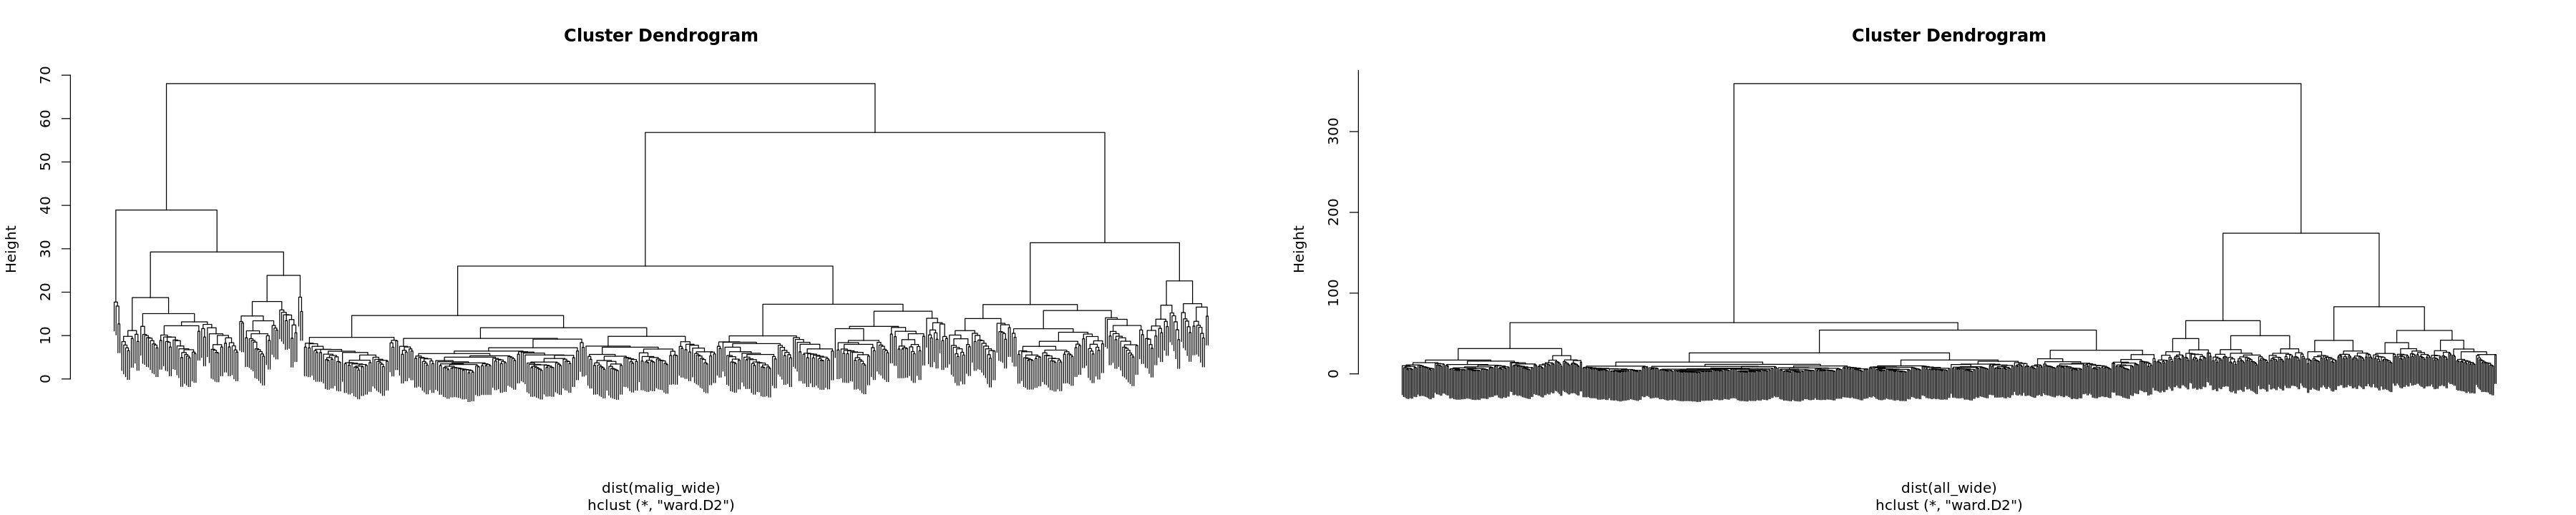

In [37]:
run_slide_cna(sn, 
              md, 
              gene_pos,
              plotDir,
              OUTPUT_DIRECTORY,
              spatial=FALSE)